In [1]:
from parameters import parameters as par
from model import Model
from modules.loader import Loader
from simulator import Simulator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pickle

In [3]:
V_sol, C_sol, par_ = Loader.load('2019-05-17T100307')

FileNotFoundError: [Errno 2] No such file or directory: '2019-05-17T100307V_sol.pkl'

import numpy as np
from model import Model
from agent import update_f, calc_a, R_tilde
from modules.interp import Interpolate3D, Majority3D
from modules.meshmapping import create_lookup_dict, create_mesh
from modules.stategrid import create_statespace, create_m_grid, create_f_grid, create_p_grid

class Simulator(Model):
        
    NUMPY_SEED = 43
    SHOCK_SCALE = 0.1
    M_INITIAL_MEAN = 50000
    M_INITIAL_SCALE = 25000
    M_MINIMUM = 10000
    FINANCIAL_LIT_START = 0
    PERM_INCOME_MEAN = 10000
    PERM_INCOME_SCALE = 4000
    
    @classmethod
    def simulate(cls, V_sol, C_sol, par, n_persons=1):
        
        """Runs simulation
        
        Notes:
        First states are initialized (for all persons)
        
        Loops the following way:
        for t in range(minimum age, maximum age):
            for person in range(number of persons):
                update state, choices
        
        Parameters
        ==========
        V_sol : Value-function solution object
        C_sol : Choice solution object
        par : parameters
        n_person : number of persons to simulate
        
        
        Returns
        =========
        states, choices, shocks
            -> all are arrays of dim (3, timesteps, n_persons)
            -> the '3' is because of 3 diff variables (both for states, choices and shocks)
        
        """
        
        np.random.seed(cls.NUMPY_SEED)
        
        # number of time steps to simulate
        timesteps =  par.max_age - par.start_age + 1
        
        # shocks are pre-simulated
        shocks = np.exp(np.random.normal(size=(3,timesteps,n_persons), scale=cls.SHOCK_SCALE))
        
        #data containers
        choices = np.empty(shape=(3,timesteps,n_persons))
        states = np.empty(shape=(3,timesteps,n_persons))
        
        #notes on subsetting:
        # [variables, timestep_index (ix NOT t), person_ix]
        
        #letting the first state be set (first period)
        for pix in range(n_persons):
            
            #draw start value for cash-on-hand for person
            m_start = np.random.normal(cls.M_INITIAL_MEAN, cls.M_INITIAL_SCALE)
            if m_start < cls.M_MINIMUM:
                m_start = 10000
            
            # draw start value for permanent income (for person)
            p_start = np.random.normal(cls.PERM_INCOME_MEAN, cls.PERM_INCOME_SCALE)
            
            # setting m, f, p
            states[0, 0, pix], states[1, 0, pix], states[2, 0, pix] = m_start, cls.FINANCIAL_LIT_START, p_start

        m_grid = create_m_grid(par)
        p_grid = create_p_grid(par)
        f_grid = create_f_grid(par)
        statespace = create_statespace(par)
       
        m, f, p = 2, 0, 0 #cannot start with zero income
        
        for ix, t in enumerate(range(par.start_age, par.max_age + 1)):
            
            print("In period: ", t, "ix: ", ix)
            
            #interpolators
            interp_c, interp_kappa, interp_i = cls.create_interpolators(C_sol,
                                                                        t, 
                                                                        statespace, 
                                                                        m_grid, 
                                                                        f_grid, 
                                                                        p_grid,
                                                                        par
                                                                       )
                                                                        
            
            for person_ix in range(n_persons):
                
                #subsetting the persons shock
                psi, xi, eps = shocks[:,ix,person_ix]
                
                #subsetting the persons states:
                m, f, p = states[:,ix,person_ix]
                
                c = interp_c.interpolate(m, f, p)
                kappa = interp_kappa.interpolate(m, f, p) 
                i = interp_i.interpolate(m, f, p)
                
                if t < par.max_age:
                    # if we are not in last periode we will need to update our states
                    # this dynamic takes care of stochastic shocks
                    m_fut, f_fut, p_fut = cls.upd_stts(t, m, f, p, c, kappa, i, psi, xi, eps, par)
                    states[:,ix + 1, person_ix] = m_fut, f_fut, p_fut
                    choices[:, ix, person_ix] = c, kappa, i
                else:
                    #if we are in last period we will consume all our cash on hand
                    choices[:, ix, person_ix] = m, 0, 0
                    
        return states, choices, shocks
                
    @classmethod
    def create_interpolators(cls, C_sol, t, statespace, m_grid, f_grid, p_grid, par):
        """Creates Interpoloation objects
        
        NOTES:
        c : interpolator
        kappa : majority voter
        i : majority voter
        
        all interpolator/majority voter objects has the method <interpolate>
        
        Parameters
        ==========
        C_sol : solution object for choices
        t : time
        statespace : statespace (need for look up dict)
        grids : m_grid, f_grid, p_grid (needed for mesh -> mesh is used for interpolation)
        parameters : par
        
        Returns
        ========
        interpolaters : interp_c, interp_kappa, interp_i
        
        """
        
        # get choices for given time period
        choices_c = C_sol[t][:,0]
        choices_kappa = C_sol[t][:,1]
        choices_i = C_sol[t][:,2]
        
        # creates look up dict need for mesh
        ld_c = create_lookup_dict(statespace, choices_c)
        ld_kappa = create_lookup_dict(statespace, choices_kappa)
        ld_i = create_lookup_dict(statespace, choices_i)
        
        # creates mesh for each choice variable
        mesh_c = create_mesh(m_grid, f_grid, p_grid, ld_c, par)
        mesh_kappa = create_mesh(m_grid, f_grid, p_grid, ld_kappa, par)
        mesh_i = create_mesh(m_grid, f_grid, p_grid, ld_i, par)
        
        # creates interpolators
        interp_c = Interpolate3D(m_grid, f_grid, p_grid, mesh_c)
        interp_kappa = Majority3D(m_grid, f_grid, p_grid, mesh_kappa, 0, 0.55)
        interp_i = Majority3D(m_grid, f_grid, p_grid, mesh_i, 0, 1)
        
        return interp_c, interp_kappa, interp_i
    
    @classmethod
    def upd_stts(cls, t, m, f, p, c, kappa, i, psi, xi, eps, par):
        
        """Update states -> dynamic of model
        
        
        Parameters
        ==========
        time : t
        states : m, f, p
        choices : c, kappa, i
        shocks : psi, xi, eps
        parameters : par
        
        Returns
        ==========
        future states: m, f, p
        """
        
        f = update_f(i, f, par) # updateting to f_t+1
        assets = calc_a(c, i, kappa, m, par)

        interest_factor = R_tilde(kappa, f, par, shock=eps)
        income = xi * (par.G * p * psi) + par.age_poly[t]

        # Future state values
        m_fut = interest_factor * assets + income
        p_fut = par.G * p * psi
        f_fut = np.float64(f)
        
        return m_fut, f_fut, p_fut

In [179]:
NUMBER_OF_PERSONS = 1000
states, choices, shocks = Simulator.simulate(V_sol, C_sol, par_, NUMBER_OF_PERSONS)

In period:  25 ix:  0
In period:  26 ix:  1
In period:  27 ix:  2
In period:  28 ix:  3
In period:  29 ix:  4
In period:  30 ix:  5
In period:  31 ix:  6
In period:  32 ix:  7
In period:  33 ix:  8
In period:  34 ix:  9
In period:  35 ix:  10
In period:  36 ix:  11
In period:  37 ix:  12
In period:  38 ix:  13
In period:  39 ix:  14
In period:  40 ix:  15
In period:  41 ix:  16
In period:  42 ix:  17
In period:  43 ix:  18
In period:  44 ix:  19
In period:  45 ix:  20
In period:  46 ix:  21
In period:  47 ix:  22
In period:  48 ix:  23
In period:  49 ix:  24
In period:  50 ix:  25
In period:  51 ix:  26
In period:  52 ix:  27
In period:  53 ix:  28
In period:  54 ix:  29
In period:  55 ix:  30
In period:  56 ix:  31
In period:  57 ix:  32
In period:  58 ix:  33
In period:  59 ix:  34
In period:  60 ix:  35
In period:  61 ix:  36
In period:  62 ix:  37
In period:  63 ix:  38
In period:  64 ix:  39
In period:  65 ix:  40
In period:  66 ix:  41
In period:  67 ix:  42
In period:  68 ix:  4

### States plot

In [181]:
FIGSIZE = (12, 18)

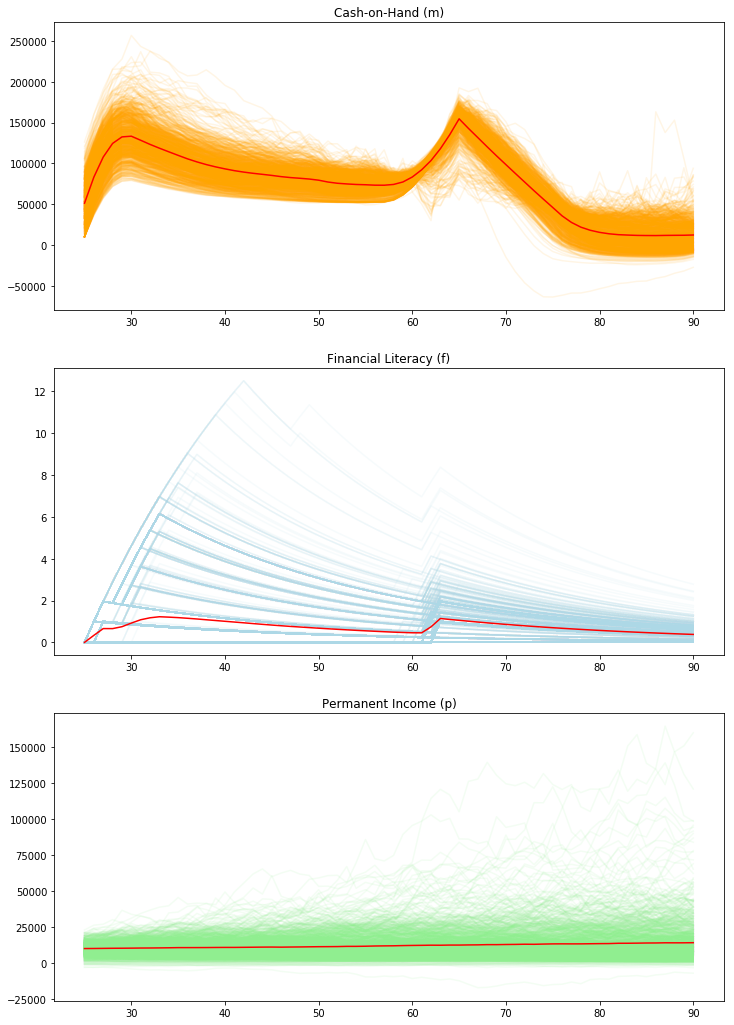

In [182]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=FIGSIZE)
ax1.set_title("Cash-on-Hand (m)")
ax1.plot(range(25, 91), states[0,:], alpha=0.1, color='orange')
ax1.plot(range(25, 91), states[0,:].mean(axis=1), color='red')

ax2.set_title("Financial Literacy (f)")
ax2.plot(range(25, 91), states[1,:], alpha=0.1, color='lightblue')
ax2.plot(range(25, 91), states[1,:].mean(axis=1), color='red')

ax3.set_title("Permanent Income (p)")
ax3.plot(range(25, 91), states[2,:], alpha=0.1, color='lightgreen')
ax3.plot(range(25, 91), states[2,:].mean(axis=1), color='red')


### Choices Plot

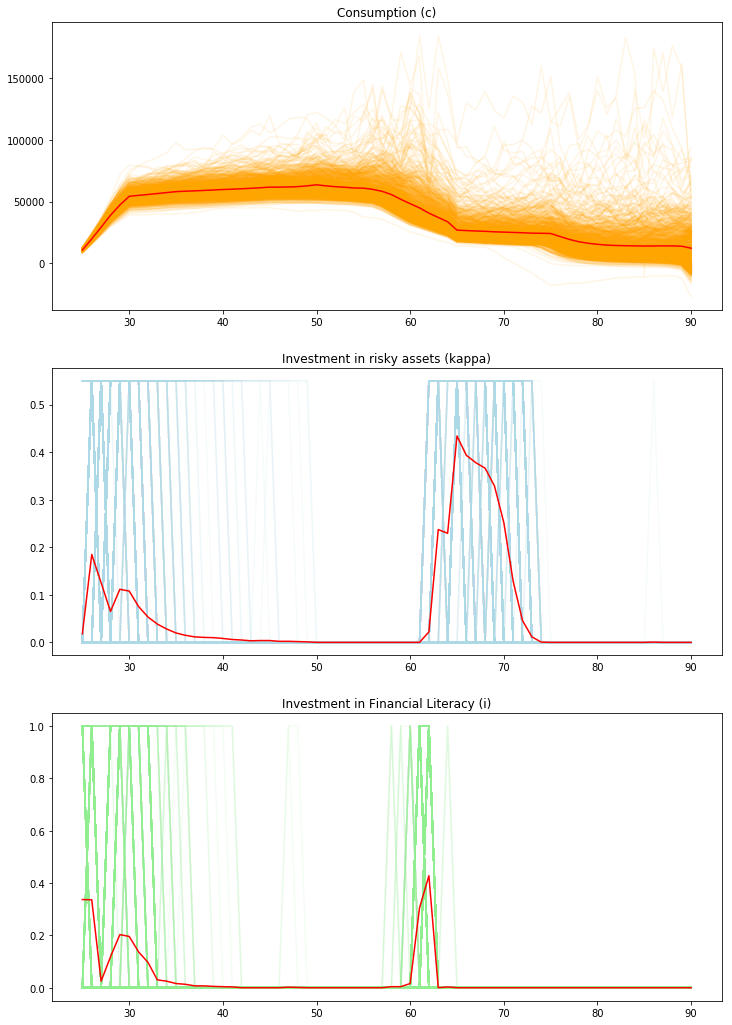

In [183]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=FIGSIZE)
ax1.set_title("Consumption (c)")
ax1.plot(range(25, 91), choices[0,:], alpha=0.1, color='orange')
ax1.plot(range(25, 91), choices[0,:].mean(axis=1), color='red')

ax2.set_title("Investment in risky assets (kappa)")
ax2.plot(range(25, 91), choices[1,:], alpha=0.1, color='lightblue')
ax2.plot(range(25, 91), choices[1,:].mean(axis=1), color='red')

ax3.set_title("Investment in Financial Literacy (i)")
ax3.plot(range(25, 91), choices[2,:], alpha=0.1, color='lightgreen')
ax3.plot(range(25, 91), choices[2,:].mean(axis=1), color='red')